## human judgement data
---
examining some of the human judgement data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
import progressbar

In [2]:
human_df = pd.read_csv('human_data.csv')
human_df.head()

,left_file,right_file,response_left,orig_file
0,'87_kriz_ssim_fc.png','87_kriz_mse_fc.png',1,'87_orig.png'
1,'90_kriz_mse_fc.png','90_kriz_ssim_fc.png',0,'90_orig.png'
2,'163_kriz_ssim_fc.png','163_kriz_mse_fc.png',1,'163_orig.png'
3,'69_kriz_ssim_fc.png','69_kriz_mse_fc.png',1,'69_orig.png'
4,'100_kriz_mse_fc.png','100_kriz_ssim_fc.png',0,'100_orig.png'


---

data in form left image location, right image location, and a binary variable indicating if the subject chose the left (1) or right (0) image as a better representation of the original. note that the order of compression switches randomly.

---

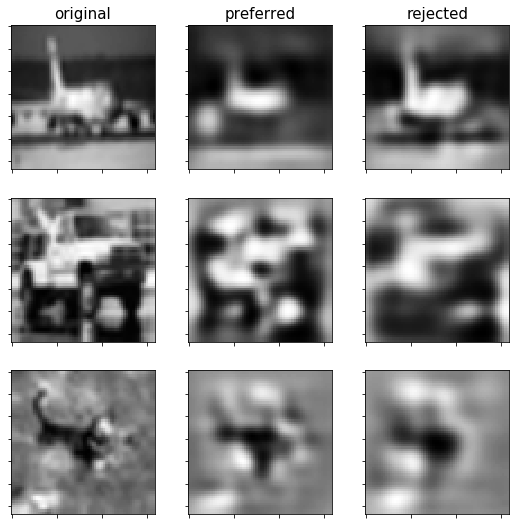

In [19]:
# data sample
f, axarr = plt.subplots(nrows=3, ncols=3, figsize=(9,9))

for ii in range(3):
    index = np.random.randint(4040)
    temp_left = mpimg.imread('iclr_images/' +  human_df['left_file'][index][1:-1])
    temp_right = mpimg.imread('iclr_images/' + human_df['right_file'][index][1:-1])
    temp_orig = mpimg.imread('iclr_images/' + human_df['orig_file'][index][1:-1])
    
    axarr[ii][0].imshow(temp_orig, cmap='gray')
    
    if human_df['response_left'][index] == 1:
        axarr[ii][1].imshow(temp_left, cmap='gray')
        axarr[ii][2].imshow(temp_right, cmap='gray')
    else:
        axarr[ii][2].imshow(temp_left, cmap='gray')
        axarr[ii][1].imshow(temp_right, cmap='gray')

for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

axarr[0,0].set_title('original', size=15)
axarr[0,1].set_title('preferred', size=15)
axarr[0,2].set_title('rejected', size=15)

# plt.savefig('human_pref.png')
plt.show()

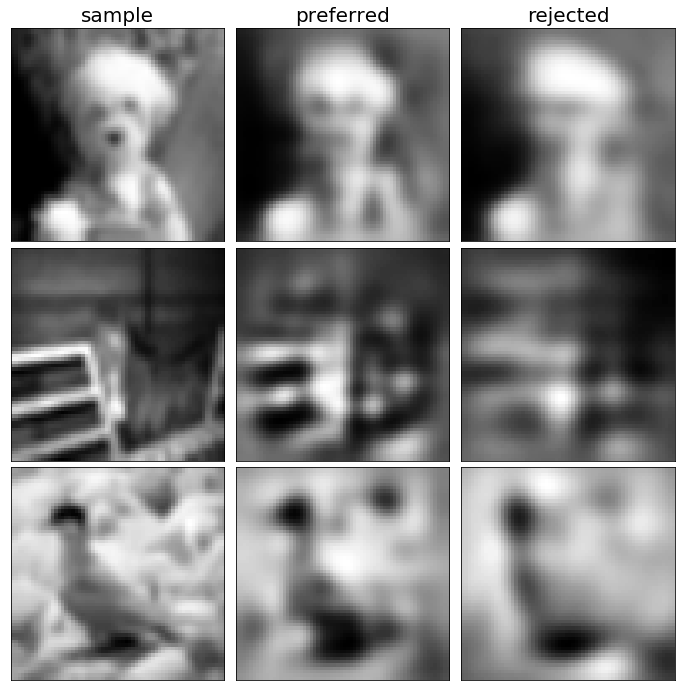

In [29]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (12,12))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.03, hspace=0.03)

ax_dict = {}
for ii in range(9):
    ax_dict[ii] = plt.subplot(gs1[ii])
    ax_dict[ii].set_xticklabels([])
    ax_dict[ii].set_yticklabels([])
    ax_dict[ii].get_xaxis().set_visible(False)
    ax_dict[ii].get_yaxis().set_visible(False)

for ii in range(3):    
    index = np.random.randint(4040)
    temp_left = mpimg.imread('iclr_images/' +  human_df['left_file'][index][1:-1])
    temp_right = mpimg.imread('iclr_images/' + human_df['right_file'][index][1:-1])
    temp_orig = mpimg.imread('iclr_images/' + human_df['orig_file'][index][1:-1])
    
    ax_dict[3*ii].imshow(temp_orig, cmap='gray')
    
    if human_df['response_left'][index] == 1:
        ax_dict[3*ii+1].imshow(temp_left, cmap='gray')
        ax_dict[3*ii+2].imshow(temp_right, cmap='gray')
    else:
        ax_dict[3*ii+2].imshow(temp_left, cmap='gray')
        ax_dict[3*ii+1].imshow(temp_right, cmap='gray')
        
ax_dict[0].set_title('sample', size=20)
ax_dict[1].set_title('preferred', size=20)
ax_dict[2].set_title('rejected', size=20)
plt.savefig('human.png')
plt.show()

In [4]:
im = Image.open('iclr_images/' +  human_df['left_file'][ii][1:-1])
test = np.asarray(im)
test

array([[57, 57, 58, ..., 65, 66, 66],
       [56, 56, 57, ..., 64, 65, 65],
       [54, 54, 54, ..., 62, 62, 62],
       ..., 
       [93, 94, 94, ..., 86, 85, 85],
       [94, 94, 94, ..., 91, 91, 91],
       [94, 94, 94, ..., 94, 94, 94]], dtype=uint8)

---

now that we have an idea of the human judgement data, we can run ssim and see how well it predicts human behavior.

In [6]:
def calculate_ssim_patch(window_orig, window_recon):
    k_1, k_2, L = 0.01, 0.03, 255
    if window_orig.shape != (11,11) or window_recon.shape != (11,11):
        raise ValueError('please check window size for SSIM calculation!')
    orig_data, recon_data = window_orig.flatten(), window_recon.flatten()
    mean_x, mean_y = np.mean(orig_data), np.mean(recon_data)
    var_x, var_y = np.var(recon_data), np.var(orig_data)
    covar = np.cov(orig_data, recon_data)[0][1]
    c_1, c_2 = (L*k_2)**2, (L*k_1)**2
    num = (2*mean_x*mean_y+c_1)*(2*covar+c_2)
    den = (mean_x**2+mean_y**2+c_1)*(var_x+var_y+c_2)
    return num/den

def calculate_ssim_image(image_orig, image_recon):
    ssim_res = []
    filter_dim = 11; image_dim = image_orig.shape[0];
    number_windows = image_dim - filter_dim + 1
    for i in range(number_windows):
        for j in range(number_windows):
            orig_window = image_orig[i:i+11, j:j+11]
            recon_window = image_recon[i:i+11, j:j+11]
            temp = calculate_ssim_patch(orig_window, recon_window)
            ssim_res.append(temp)
    return np.asarray(ssim_res)

In [14]:
bar = progressbar.ProgressBar()
correct = 0
for ii in bar(range(len(human_df['left_file']))):
    left_im = Image.open('iclr_images/' +  human_df['left_file'][ii][1:-1])
    left_im_pix = np.asarray(left_im)
    right_im = Image.open('iclr_images/' +  human_df['right_file'][ii][1:-1])
    right_im_pix = np.asarray(right_im)
    orig_im = Image.open('iclr_images/' +  human_df['orig_file'][ii][1:-1])
    orig_im_pix = np.asarray(orig_im)
    
    left_ssim = calculate_ssim_image(orig_im_pix, left_im_pix)
    right_ssim = calculate_ssim_image(orig_im_pix, right_im_pix)
    
    ssims = [np.mean(right_ssim), np.mean(left_ssim)]
    if np.argmax(ssims) == human_df['response_left'][ii]:
        correct += 1
    

100% (4040 of 4040) |#####################| Elapsed Time: 0:45:58 Time: 0:45:58


In [17]:
correct, correct/4040

(3451, 0.8542079207920792)

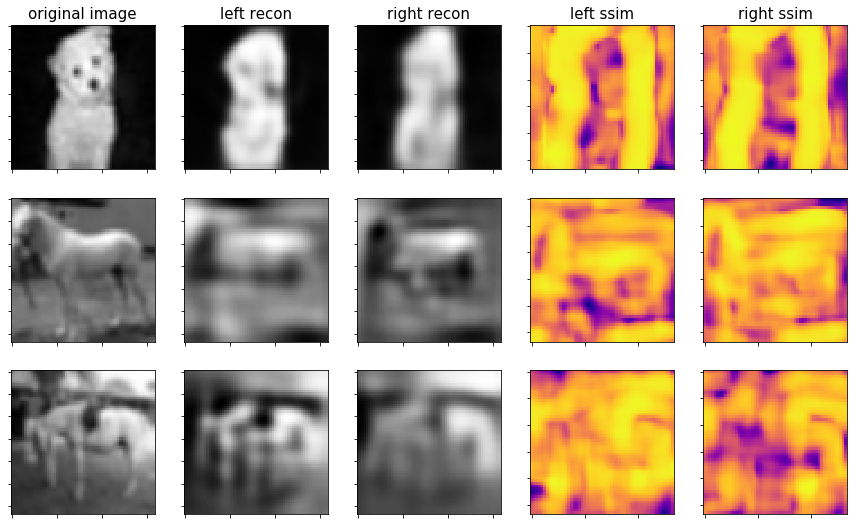

In [8]:
f, axarr = plt.subplots(nrows=3, ncols=5, figsize=(15,9))

for ii in range(3):
    index = np.random.randint(4040)
    left_im = Image.open('iclr_images/' +  human_df['left_file'][index][1:-1])
    left_im_pix = np.asarray(left_im)
    right_im = Image.open('iclr_images/' +  human_df['right_file'][index][1:-1])
    right_im_pix = np.asarray(right_im)
    orig_im = Image.open('iclr_images/' +  human_df['orig_file'][index][1:-1])
    orig_im_pix = np.asarray(orig_im)
    
    left_ssim = calculate_ssim_image(orig_im_pix, left_im_pix)
    right_ssim = calculate_ssim_image(orig_im_pix, right_im_pix)
    
    axarr[ii][0].imshow(orig_im_pix, cmap='gray')
    axarr[ii][1].imshow(left_im_pix, cmap='gray')
    axarr[ii][2].imshow(right_im_pix, cmap='gray')
    axarr[ii][3].imshow(np.reshape(left_ssim,(54,54)), cmap='plasma')
    axarr[ii][4].imshow(np.reshape(right_ssim,(54,54)), cmap='plasma')

axarr[0,0].set_title('original image', size=15)
axarr[0,1].set_title('left recon', size=15)
axarr[0,2].set_title('right recon', size=15)
axarr[0,3].set_title('left ssim', size=15)
axarr[0,4].set_title('right ssim', size=15)

for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# plt.savefig('human_judge2.png')

plt.show()